In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from scipy import cluster as scl
from scipy import io as sio
from matplotlib import pyplot as plt
from nilearn import plotting as nlp
import pandas as pd

In [3]:
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
sim_p = os.path.join(path_root,'subtype_5_spm_LANGUAGE_18-Oct-2017/networks/story/subtype_story.mat')

In [4]:
%load_ext oct2py.ipython

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [55]:
%%octave -i sim_p
sim_matrix= load(sim_p);

In [57]:
%%octave -i sim_p
fieldnames(sim_matrix)

ans = 

{

  [1,1] = subj_order

  [2,1] = sim_matrix

  [3,1] = sub

  [4,1] = hier

  [5,1] = part

  [6,1] = list_subject

}

In [10]:
%%octave
mat = sim_matrix.sim_matrix;

In [12]:
%%octave
% Cluster subjects
hier = niak_hierarchical_clustering(mat);

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 Done ! 

In [24]:
%%octave -o sil,intra,inter,hier
[sil,intra,inter] = niak_build_avg_silhouette(mat,hier);

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 Done ! 

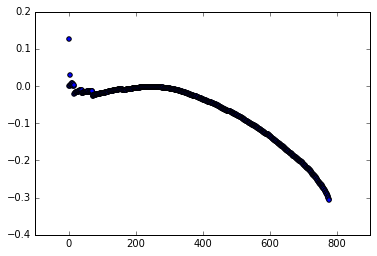

In [37]:
plt.scatter(range(len(sil)),sil)

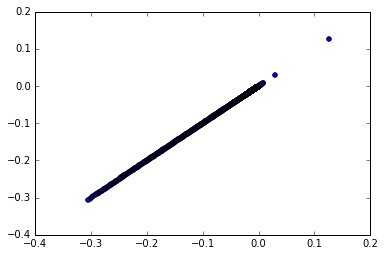

In [30]:
plt.scatter(sil,sil)

In [6]:
mat_subt = sio.loadmat(sim_p)

In [6]:
# extract partitioning of clrusters from mat file 
%octave_push sim_p
%octave mat_load = load(sim_p);
%octave_pull mat_load
stack_subj_part = np.concatenate((np.vstack(mat_load['list_subject']),mat_load['part'].astype('int')),axis=1)

In [7]:
# make dataframe
subj_part_df = pd.DataFrame(stack_subj_part,columns=['ID','part'])
subj_part_df.loc[:,'part'] = subj_part_df.part.astype(int)

In [21]:
subj_part_df.dtypes

ID      object
part     int64
dtype: object

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)


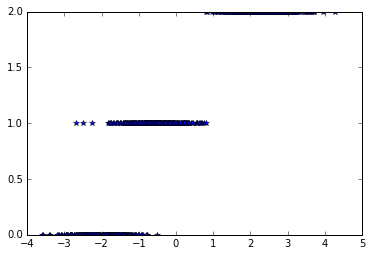

In [29]:
plt.plot(X[:,0],y,'*')

In [67]:
sim = a['sim_matrix']
mask = np.triu(sim, 1).astype(bool)
svec = sim[mask]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

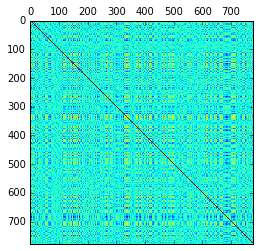

In [14]:
plt.matshow(sim)

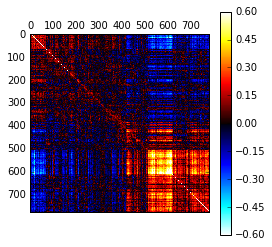

In [15]:
plt.matshow(sim[:, order][order, :], vmin=-0.6, vmax=0.6, cmap=nlp.cm.cold_hot)
plt.colorbar()

In [29]:
b = sim[order[:350], :][:, order[:350]]

In [30]:
b.shape

(350, 350)

In [32]:
sim = b
mask = np.triu(sim, 1).astype(bool)
svec = sim[mask]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

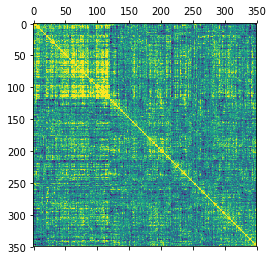

In [34]:
plt.matshow(b[order, :][:, order], vmin=-0.2, vmax=0.2)

In [22]:
np.max(sim[sim!=1])

0.86614530874461482